In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Init Plugin
Init Graph Optimizer
Init Kernel
Num GPUs Available:  1


In [2]:
import numpy as np
import cv2
import sys
import glob
from matplotlib import pyplot as plt

import random
import time

import torch
import torchvision
import torchvision.transforms as T

In [3]:
print("Python", sys.version)
print("Numpy", np.__version__)
print("OpenCV", cv2.__version__)
print("torch", torch.__version__)
print("torchvision", torchvision.__version__)

Python 3.8.10 | packaged by conda-forge | (default, May 11 2021, 06:27:18) 
[Clang 11.1.0 ]
Numpy 1.19.5
OpenCV 4.5.1
torch 1.9.0
torchvision 0.10.0a0


In [4]:
################# Check NVIDIA GPU availability #################

has_cuda_gpu = torch.cuda.is_available()
print( "CUDA support:", torch.cuda.is_available() )
print( "The number of CUDA GPUs:", torch.cuda.device_count() )

if has_cuda_gpu:
    gpu_id = torch.cuda.current_device()
    print( "Index of current GPU:", gpu_id )
    print( "Detail of the current CUDA GPU:" )
    print( "    Address:", torch.cuda.device(gpu_id) )
    print( "    Device name:", torch.cuda.get_device_name(gpu_id) )

CUDA support: False
The number of CUDA GPUs: 0


In [5]:
################# Load the pre-trained model from PyTorch #################

model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [6]:
################# Randomly assign different colors for all COCO classes #################

COCO_INSTANCE_CATEGORY_NAMES = [ 
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

import colorsys
n_class = len(COCO_INSTANCE_CATEGORY_NAMES)
hsv = [ ( i/n_class, 1.0, 1.0 ) for i in range( n_class ) ]
COLOR_RGB = list( map(lambda c: colorsys.hsv_to_rgb(*c), hsv) )
random.seed(42)
random.shuffle(COLOR_RGB)

In [7]:
################# Define a function for performing instance segmentation #################

def instance_segmentation( img_cv_bgr, min_confidence=0.5, gpu=True, show_bounding_box=True, show_mask=True ):
    # Nothing to show. Just return the input image.
    if show_mask==False and show_bounding_box==False:
        return img_cv_bgr

    # Convert from BGR to RGB (channel-last)
    img = cv2.cvtColor( img_cv_bgr, cv2.COLOR_BGR2RGB )

    # Convert the numpy input image (channel-last) to PyTorch's tensor (channel-first)
    transform = T.Compose([T.ToTensor()])
    img = transform(img)
  
    if gpu:
        #  Send our model to the "current device" that is set with torch.cuda.set_device(device)
        model.cuda()
        img = img.cuda()
    else:
        model.cpu()
        img = img.cpu()
        
    # Pass the input image to Mask R-CNN model
    # There is only one result in this function (i.e., only pred[0]) as we pass only one image to the model
    pred = model( [ img ] )
    
    # Create a list to store class names for each detected object
    pred_classname = [ COCO_INSTANCE_CATEGORY_NAMES[x] for x in  pred[0]['labels'] ]
    
    # The number of detected objects in 'the pred[0]' input image
    N = len( pred[0]['scores'] )  
    
    # Loop for each detected object in 'pred[0]'
    img_result = img_cv_bgr.copy()
    for j in range( N ):       
        # Too low confidence, skip it
        if pred[0]['scores'][j] < min_confidence:
            continue
        
        # The BGR color (0-255) of this object
        # 1. Reverse the list from [r,g,b] to [b,g,r] by [::-1] slicing technique
        # 2. Convert the list to numpy array in order to perform element-wise multiplication
        # 3. Scale the value from 0-1 to 0-255
        color = np.array( COLOR_RGB[ pred[0]['labels'][j] ][ ::-1 ] ) * 255
        
        if show_mask:
            # Convert from (1,row,col) torch tensor to (row,col,1) OpenCV's image
            # Pixels in mask have [0,1] range of intensity
            mask = pred[0]['masks'][j].cpu().detach().numpy()
            mask = np.moveaxis(mask, 0, 2)
            
            # Duplicate the 1-channel mask and create a 3-channel mask image 
            # Scale the values from 0-1 to 0-255
            mask_3copy = np.zeros_like( img_cv_bgr )
            mask_3copy[ :, :, 0 ] = mask[ :, :, 0 ] * 255
            mask_3copy[ :, :, 1 ] = mask[ :, :, 0 ] * 255
            mask_3copy[ :, :, 2 ] = mask[ :, :, 0 ] * 255
            
            # Create a BGR channel-last color mask (color pixel=object, black pixel=non-object) of the same size as input image
            # Only pixels with high confidence will be assigned color, otherwise they will be set to black (0,0,0)
            mask_bgr = np.zeros_like( img_cv_bgr )
            mask_bgr[ :, :, : ] = color
            mask_bgr[ mask_3copy < min_confidence * 255 ] = 0
        
            # Overlay the color mask on the output image
            img_result = cv2.addWeighted( img_result, 1, mask_bgr, 0.5, 0 )
        
        if show_bounding_box:
            # Ensure the bounding box is defined by integer
            x0, y0, x1, y1 = map(int, pred[0]['boxes'][j])
            
            cv2.rectangle( img_result, (x0,y0), (x1,y1),color=color, thickness=2 )
            
            txt = pred_classname[ j ] + " " + str( "{:.2f}".format( pred[0]['scores'][j].cpu().detach().numpy() ) )
            cv2.putText( img_result, 
                               txt, (x0,y0-5), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.55, color,thickness=2)
        
    # Return the result image
    return img_result

In [8]:
dataset_path = "output/20210818_0025/*.jpg"
files = glob.glob(dataset_path) 

/Users/farofang/miniforge3/envs/mlp/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /tmp/pip-req-build-4zyfwhmc/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/var/folders/81/801rlldj66b9mqn09r7s37jr0000gn/T/ipykernel_31920/3782612281.py:21: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  fig.canvas.set_window_title('OpenCV')


output/20210818_0025/00_25_40_1.jpg


/var/folders/81/801rlldj66b9mqn09r7s37jr0000gn/T/ipykernel_31920/3782612281.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(15,8))


output/20210818_0025/00_25_39_1.jpg


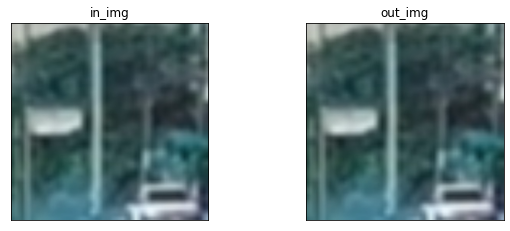

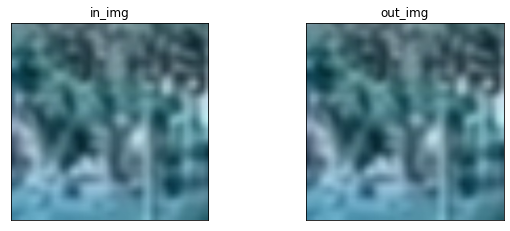

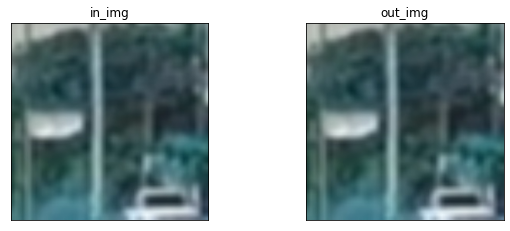

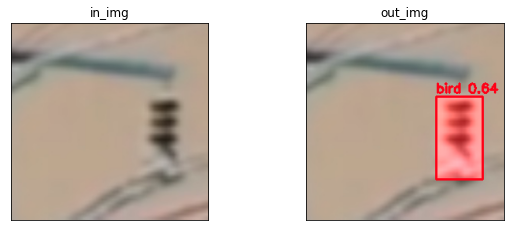

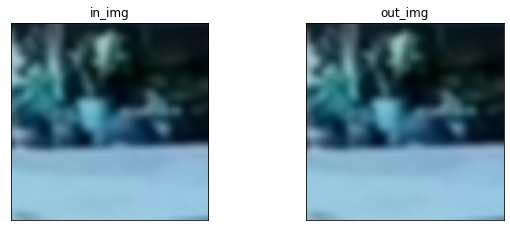

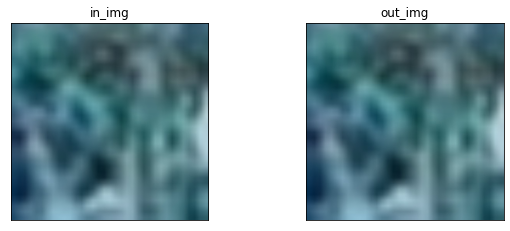

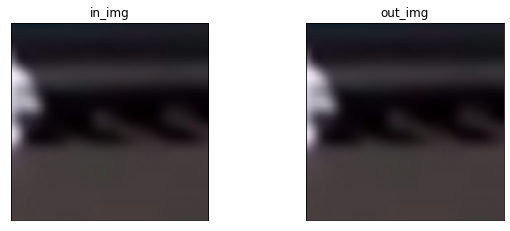

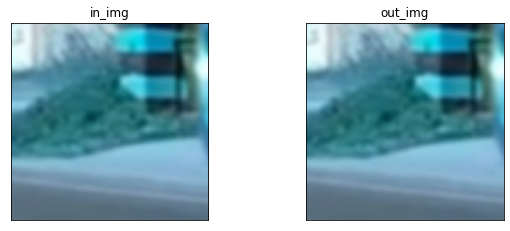

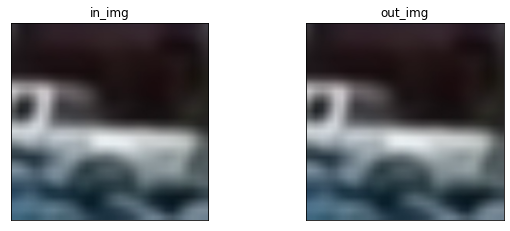

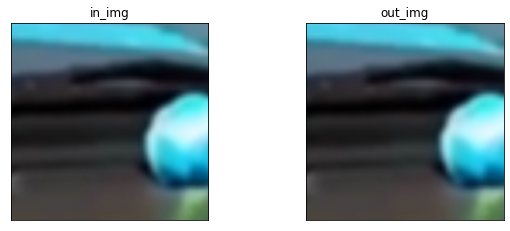

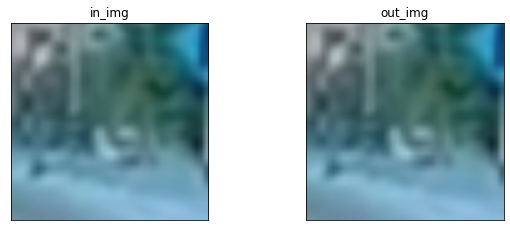

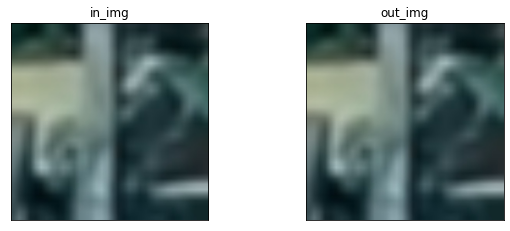

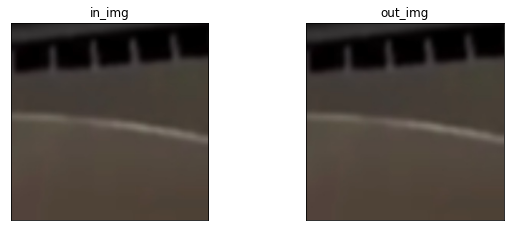

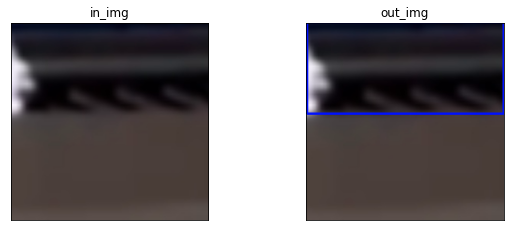

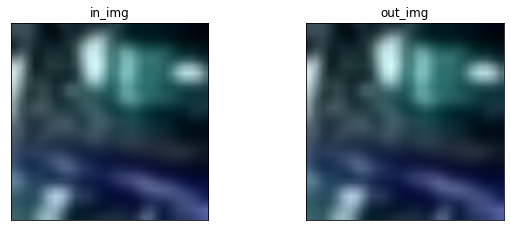

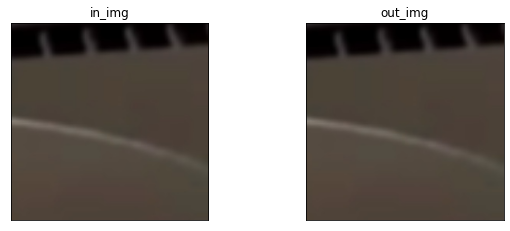

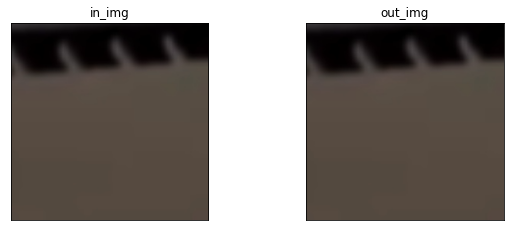

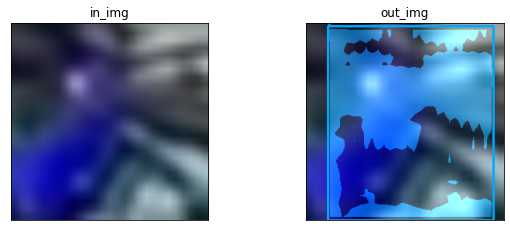

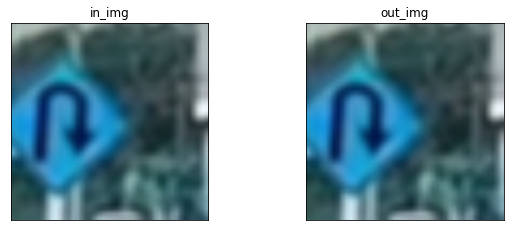

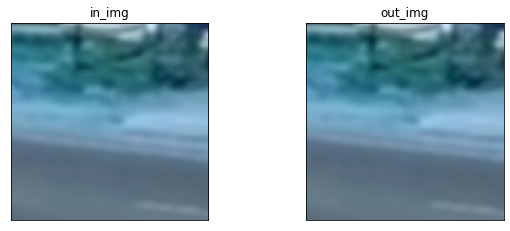

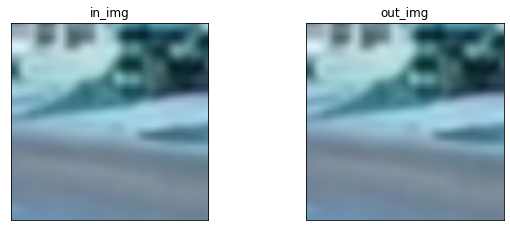

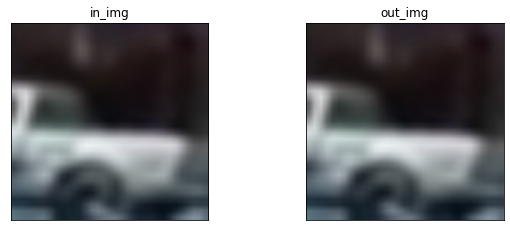

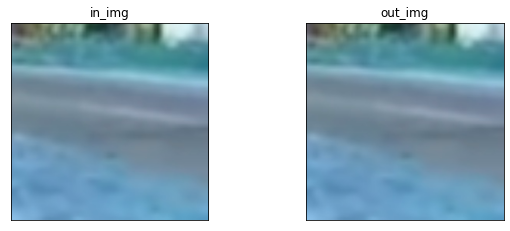

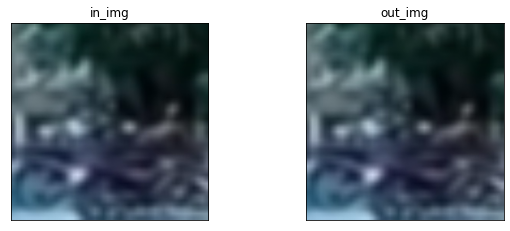

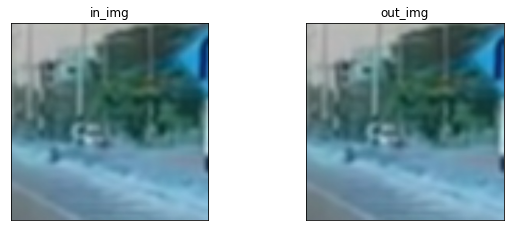

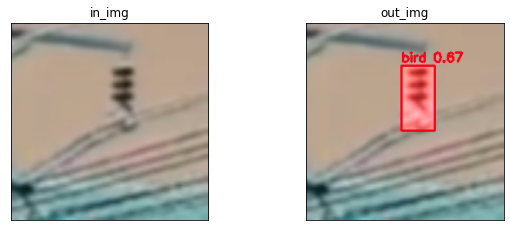

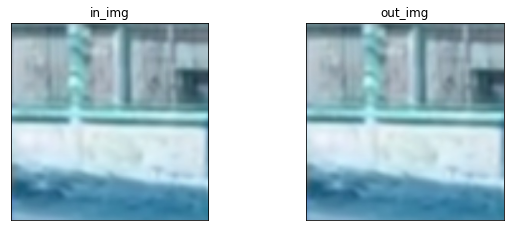

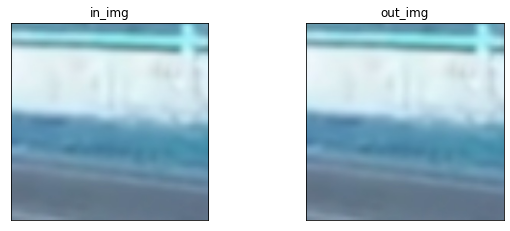

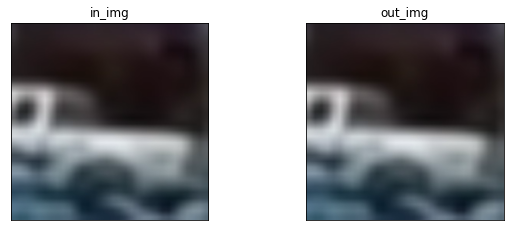

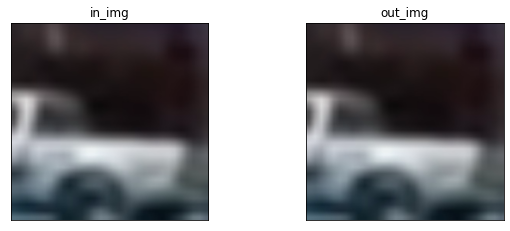

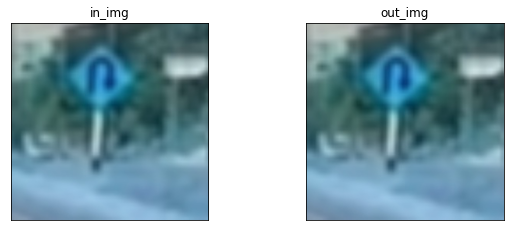

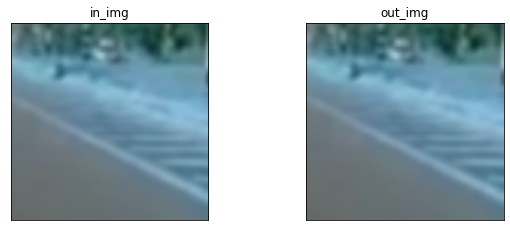

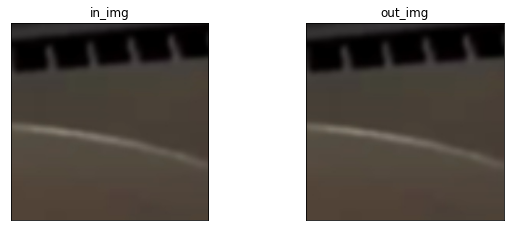

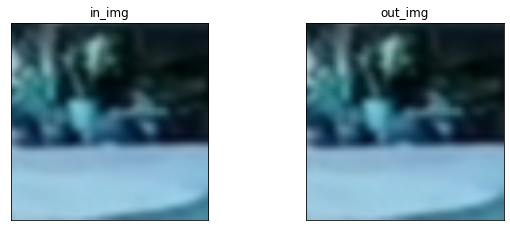

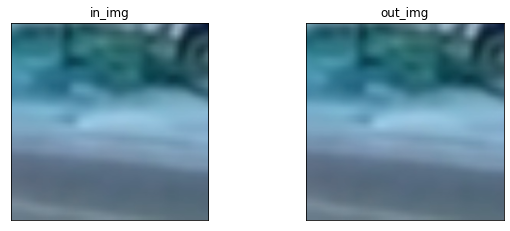

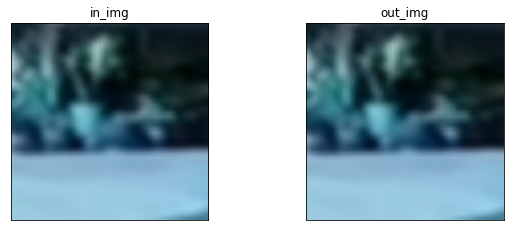

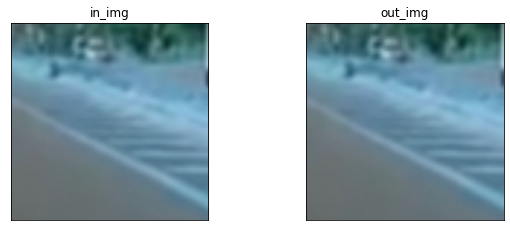

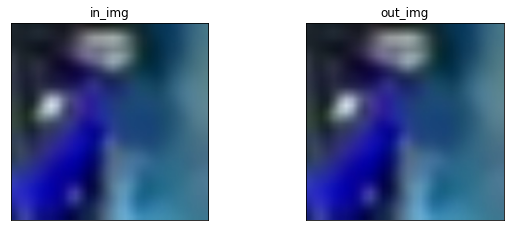

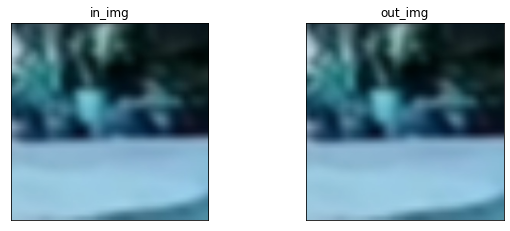

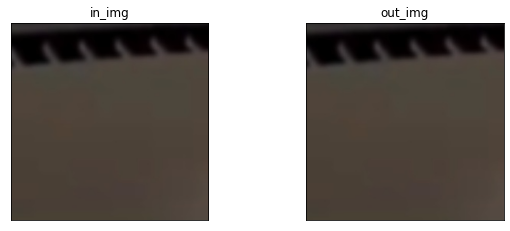

In [9]:
def get_mark(dir):
    in_img = cv2.imread(dir)

    # scale_percent = 40 # percent of original size
    # width = int(in_img.shape[1] * scale_percent / 100)
    # height = int(in_img.shape[0] * scale_percent / 100)
    # dim = (width, height)

    # # resize image
    # in_img = cv2.resize(in_img, dim, interpolation = cv2.INTER_AREA)
    try:
        out_img = instance_segmentation(in_img, gpu=has_cuda_gpu)
        # cv2.imshow("Mask R-CNN by PyTorch", np.hstack( (in_img,out_img) ) )

        # title
        titles = [ 'in_img', 'out_img']
        images = [ in_img, out_img]

        # Show all resultant images using pyplot
        fig = plt.figure(figsize=(15,8))
        fig.canvas.set_window_title('OpenCV')
        for i in range(len(titles)):
            plt.subplot(2,3,i+1),plt.imshow(images[i],'gray')
            plt.title(titles[i])
            plt.xticks([]),plt.yticks([])
    except:
        print(dir)

for item in files:
    get_mark(item)